# Model Evaluation: Discriminative vs Generative Models on SLAKE

This notebook is **evaluation-only** (no training).

It loads:
- best checkpoints for:
  - CNN–LSTM (Frozen Backbone)
  - CNN–LSTM (Unfrozen Backbone)
  - BLIP (LoRA)
- saved `history.json` and `test_results.json` from each model's training run

Then it produces:
1. Result tables (Overall / OPEN / CLOSED)
2. Training curve comparison (Frozen vs Unfrozen CNN)
3. Model comparison (CNNs vs BLIP)
4. Per-class long-tail analysis (best CNN)
5. Qualitative examples (CNN vs BLIP)


## 1. Import & Setup

In [ ]:
import json
import random
import textwrap
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm

from woa7015_medvqa.v2.data.collate import (
    collate_fn_blip,
    collate_fn_classify,
)
from woa7015_medvqa.v2.data.slake import SLAKEDataset
from woa7015_medvqa.v2.data.tokenizers import (
    build_answer_vocab,
    build_question_vocab,
    make_answer_encoder,
    make_question_encoder,
)
from woa7015_medvqa.v2.data.transforms import image_transform
from woa7015_medvqa.v2.eval.metrics import (
    compute_text_metrics,
    split_indices_by_answer_type,
)
from woa7015_medvqa.v2.models.blip_lora import build_blip_with_lora
from woa7015_medvqa.v2.models.cnn_lstm import CNNLSTMClassifier
from woa7015_medvqa.v2.utils import (
    count_params,
    load_checkpoint,
    plot_history,
    seed_everything,
)


In [2]:
seed_everything(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

PROJECT_ROOT = Path.cwd().parent
DATASET_DIR = PROJECT_ROOT / "data/SLAKE"
TRAIN_JSON = DATASET_DIR / "train.json"

# From your setup
MAX_LEN = 32  # question max length
MAX_WORDS = 290  # question vocab size
TOPK_ANS = 220  # top-k unique answers (cover all answers in train set)

# Checkpoints
CKPT_ROOT = PROJECT_ROOT / "checkpoints"

CNN_FROZEN_DIR = CKPT_ROOT / "cnn_lstm_frozen"
CNN_UNFROZEN_DIR = CKPT_ROOT / "cnn_lstm_unfrozen"
BLIP_DIR = CKPT_ROOT / "blip_lora"

NUM_WORKERS = 0
BATCH_SIZE_CNN = 32
BATCH_SIZE_BLIP = 8

print("CNN Frozen:", CNN_FROZEN_DIR)
print("CNN Unfrozen:", CNN_UNFROZEN_DIR)
print("BLIP:", BLIP_DIR)


Device: cuda
CNN Frozen: d:\jherng\Workspace\university\masters\courses\year2526_sem1\woa7015_advanced_machine_learning\alt_assessment\woa7015-medvqa\checkpoints\cnn_lstm_frozen
CNN Unfrozen: d:\jherng\Workspace\university\masters\courses\year2526_sem1\woa7015_advanced_machine_learning\alt_assessment\woa7015-medvqa\checkpoints\cnn_lstm_unfrozen
BLIP: d:\jherng\Workspace\university\masters\courses\year2526_sem1\woa7015_advanced_machine_learning\alt_assessment\woa7015-medvqa\checkpoints\blip_lora


## 2. Load Results from Previous Training Runs

In [3]:
def load_json(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def results_to_df(results: dict, model_name: str) -> pd.DataFrame:
    rows = []
    for subset, metrics in results.items():
        row = {"model": model_name, "subset": subset.upper()}
        row.update(metrics)
        rows.append(row)
    df = pd.DataFrame(rows)
    for col in df.columns:
        if col not in ["model", "subset"]:
            df[col] = df[col].astype(float)
    return df


cnn_frozen_history = load_json(CNN_FROZEN_DIR / "history.json")
cnn_frozen_test = load_json(CNN_FROZEN_DIR / "test_results.json")

cnn_unfrozen_history = load_json(CNN_UNFROZEN_DIR / "history.json")
cnn_unfrozen_test = load_json(CNN_UNFROZEN_DIR / "test_results.json")

blip_history = load_json(BLIP_DIR / "history.json")
blip_test = load_json(BLIP_DIR / "test_results.json")


## 3. Dataset and DataLoader Setup

In [4]:
# tokenizers (must match training)
q_vocab, q2id = build_question_vocab(
    str(TRAIN_JSON), max_words=MAX_WORDS, english_only=True
)
encode_question = make_question_encoder(q2id, max_len=MAX_LEN)

ans_vocab, ans2id, id2ans = build_answer_vocab(
    str(TRAIN_JSON), topk=TOPK_ANS, english_only=True
)
encode_answer = make_answer_encoder(ans2id)

# CNN dataset (tokenized)
test_ds_cls = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="test",
    english_only=True,
    image_transform=image_transform,
    question_transform=encode_question,
    answer_transform=encode_answer,
)

# BLIP dataset (raw)
test_ds_blip = SLAKEDataset(
    root_dir=DATASET_DIR,
    split="test",
    english_only=True,
)


test_loader_cls = DataLoader(
    test_ds_cls,
    batch_size=BATCH_SIZE_CNN,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_classify,
)

# NOTE: BLIP processor/model will be loaded below, then we wrap collate_fn_blip with processor


## 4. Load Models from Checkpoints

In [5]:
def print_params(name: str, model: torch.nn.Module):
    total, trainable = count_params(model)
    print(f"{name}: total={total:,} | trainable={trainable:,}")


# ---- CNN Frozen ----
cnn_frozen = CNNLSTMClassifier(
    num_answers=len(ans_vocab),
    question_vocab_size=len(q_vocab),
    freeze_cnn=True,
)

load_checkpoint(cnn_frozen, str(CNN_FROZEN_DIR / "best.pt"))
print_params("CNN Frozen", cnn_frozen)

# ---- CNN Unfrozen ----
cnn_unfrozen = CNNLSTMClassifier(
    num_answers=len(ans_vocab),
    question_vocab_size=len(q_vocab),
    freeze_cnn=False,
)

load_checkpoint(cnn_unfrozen, str(CNN_UNFROZEN_DIR / "best.pt"))
print_params("CNN Unfrozen", cnn_unfrozen)

# ---- BLIP LoRA ----
processor, blip_lora = build_blip_with_lora(r=8, alpha=32, dropout=0.05)
blip_lora
load_checkpoint(blip_lora, str(BLIP_DIR / "best.pt"))
print_params("BLIP LoRA", blip_lora)

# BLIP loader depends on processor
test_loader_blip = DataLoader(
    test_ds_blip,
    batch_size=BATCH_SIZE_BLIP,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=partial(collate_fn_blip, processor=processor),
)

# NOTE: Don't put in GPU first, my RTX5060 can't handle it T_T, only 8GB VRAM

CNN Frozen: total=12,943,901 | trainable=1,767,389
CNN Unfrozen: total=12,943,901 | trainable=12,943,901
trainable params: 2,064,384 || all params: 363,294,524 || trainable%: 0.5682
BLIP LoRA: total=363,294,524 | trainable=2,064,384


## 5. Training Curve Histories of All Models

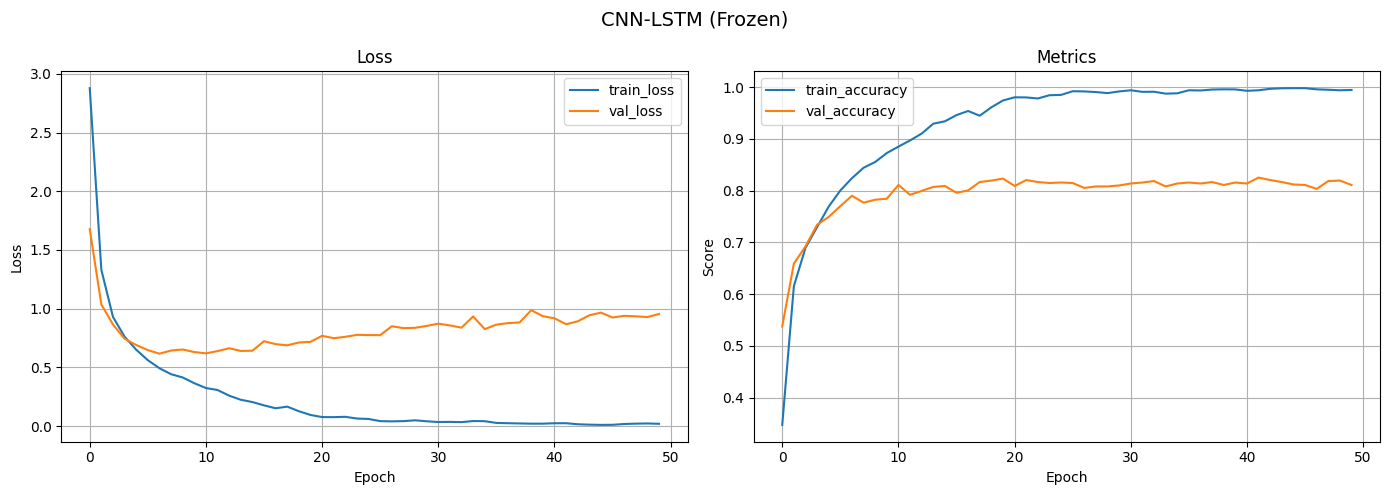

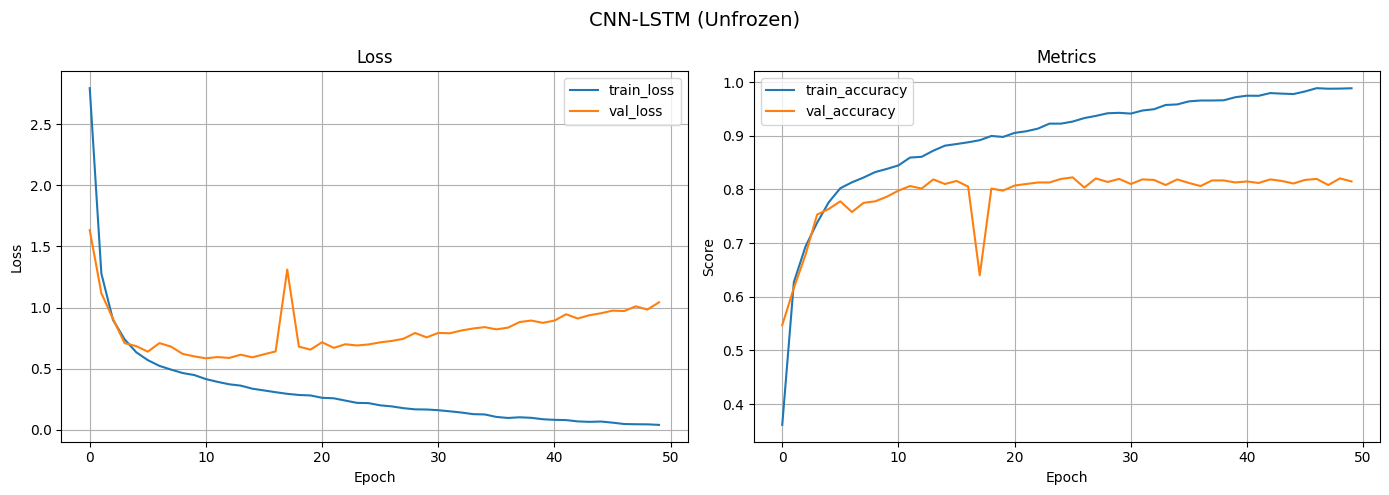

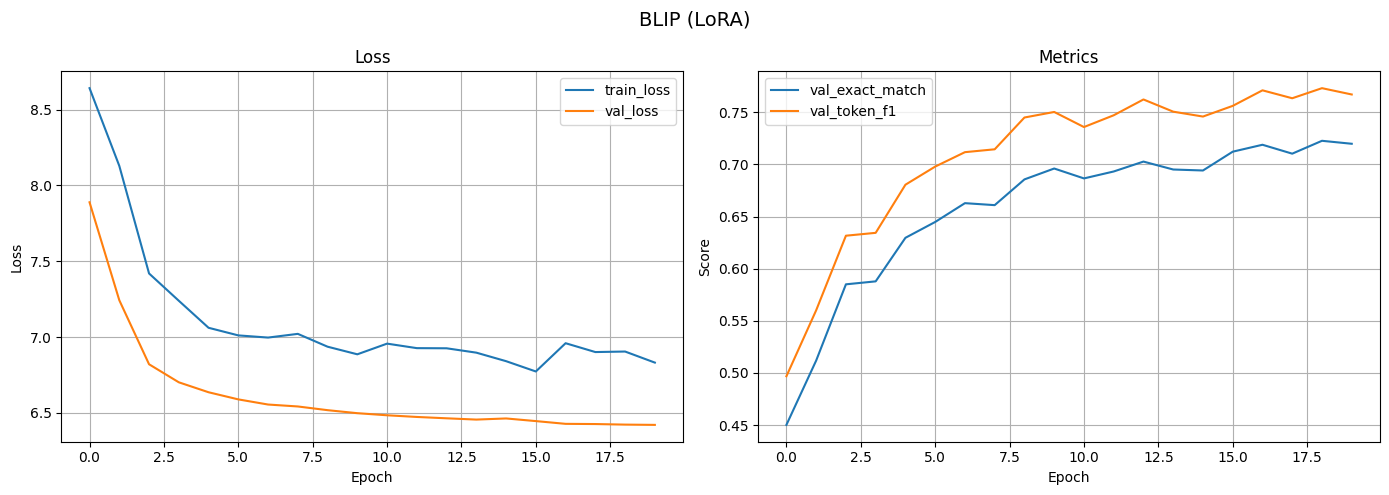

In [6]:
plot_history(cnn_frozen_history, "CNN-LSTM (Frozen)")
plot_history(cnn_unfrozen_history, "CNN-LSTM (Unfrozen)")
plot_history(blip_history, "BLIP (LoRA)")


## 6. Discriminative Models: An Analysis

### 6.1. CNN-LSTM Frozen vs Unfrozen Backbone: Which is Better?

In [7]:
df_discriminative = pd.concat(
    [
        results_to_df(cnn_frozen_test, "CNN-LSTM (Frozen)"),
        results_to_df(cnn_unfrozen_test, "CNN-LSTM (Unfrozen)"),
    ],
    ignore_index=True,
).round(4)
df_discriminative = df_discriminative.fillna("-")
df_discriminative

,model,subset,accuracy,macro_f1,top5_accuracy,loss
0,CNN-LSTM (Frozen),OVERALL,0.7983,0.4758,0.9576,0.9709
1,CNN-LSTM (Frozen),OPEN,0.7767,0.4718,0.9318,-
2,CNN-LSTM (Frozen),CLOSED,0.8317,0.6095,0.9976,-
3,CNN-LSTM (Unfrozen),OVERALL,0.7766,0.4350,0.9576,0.8657
4,CNN-LSTM (Unfrozen),OPEN,0.7473,0.4238,0.9318,-
5,CNN-LSTM (Unfrozen),CLOSED,0.8221,0.6600,0.9976,-


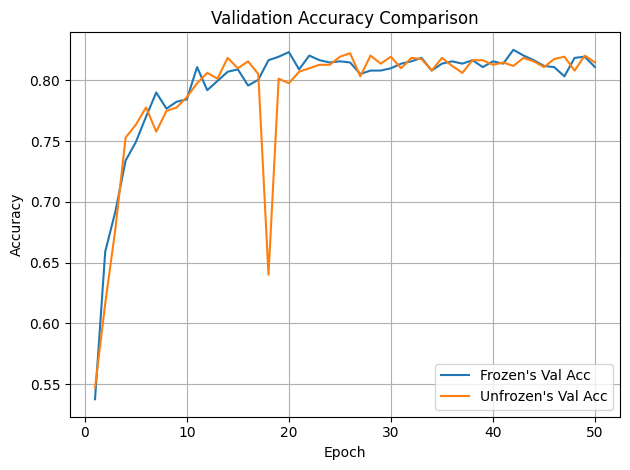

In [8]:
def plot_val_curves(hist_a: dict, hist_b: dict, name_a="Frozen", name_b="Unfrozen"):
    epochs_a = np.arange(1, len(hist_a["val_loss"]) + 1)
    epochs_b = np.arange(1, len(hist_b["val_loss"]) + 1)
    # val accuracy
    plt.plot(epochs_a, hist_a["val_accuracy"], label=f"{name_a} Val Acc")
    plt.plot(epochs_b, hist_b["val_accuracy"], label=f"{name_b} Val Acc")
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_val_curves(cnn_frozen_history, cnn_unfrozen_history, "Frozen's", "Unfrozen's")

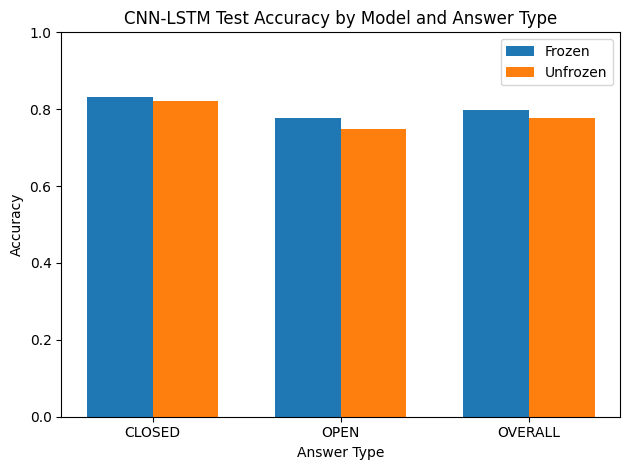

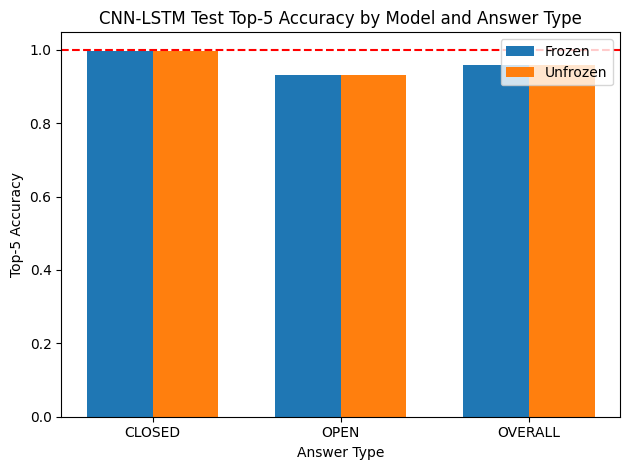

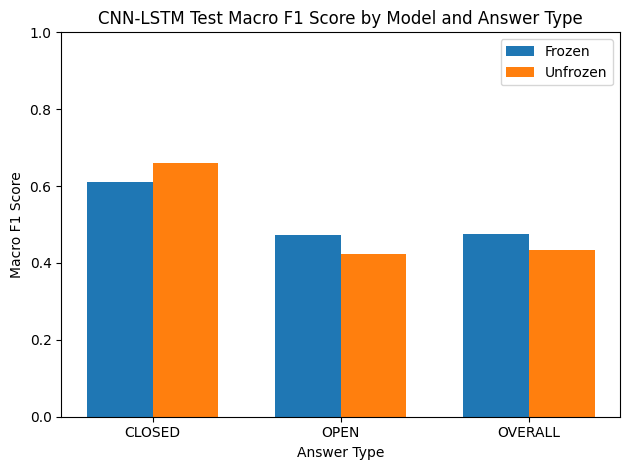

In [9]:
# Bar chart comparison with subbar
# x axis: open/closed/overall, y axis: accuracy
# bars: frozen vs unfrozen
labels = ["CLOSED", "OPEN", "OVERALL"]
frozen_accs = [
    cnn_frozen_test["closed"]["accuracy"],
    cnn_frozen_test["open"]["accuracy"],
    cnn_frozen_test["overall"]["accuracy"],
]
unfrozen_accs = [
    cnn_unfrozen_test["closed"]["accuracy"],
    cnn_unfrozen_test["open"]["accuracy"],
    cnn_unfrozen_test["overall"]["accuracy"],
]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, frozen_accs, width, label="Frozen")
rects2 = ax.bar(x + width / 2, unfrozen_accs, width, label="Unfrozen")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy")
ax.set_title("CNN-LSTM Test Accuracy by Model and Answer Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Answer Type")
ax.set_ylim(0, 1)
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()

# Top-5 accuracy comparison
labels = ["CLOSED", "OPEN", "OVERALL"]
frozen_accs = [
    cnn_frozen_test["closed"]["top5_accuracy"],
    cnn_frozen_test["open"]["top5_accuracy"],
    cnn_frozen_test["overall"]["top5_accuracy"],
]
unfrozen_accs = [
    cnn_unfrozen_test["closed"]["top5_accuracy"],
    cnn_unfrozen_test["open"]["top5_accuracy"],
    cnn_unfrozen_test["overall"]["top5_accuracy"],
]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, frozen_accs, width, label="Frozen")
rects2 = ax.bar(x + width / 2, unfrozen_accs, width, label="Unfrozen")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Top-5 Accuracy")
ax.set_title("CNN-LSTM Test Top-5 Accuracy by Model and Answer Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Answer Type")
# Draw line at y=1
ax.axhline(y=1, color="r", linestyle="--")
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()

# Macro F1 comparison
labels = ["CLOSED", "OPEN", "OVERALL"]
frozen_f1s = [
    cnn_frozen_test["closed"]["macro_f1"],
    cnn_frozen_test["open"]["macro_f1"],
    cnn_frozen_test["overall"]["macro_f1"],
]
unfrozen_f1s = [
    cnn_unfrozen_test["closed"]["macro_f1"],
    cnn_unfrozen_test["open"]["macro_f1"],
    cnn_unfrozen_test["overall"]["macro_f1"],
]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, frozen_f1s, width, label="Frozen")
rects2 = ax.bar(x + width / 2, unfrozen_f1s, width, label="Unfrozen")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Macro F1 Score")
ax.set_title("CNN-LSTM Test Macro F1 Score by Model and Answer Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Answer Type")
ax.set_ylim(0, 1)
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()

In [10]:
best_cnn_name = (
    "CNN-LSTM (Frozen)"
    if cnn_frozen_test["overall"]["accuracy"]
    >= cnn_unfrozen_test["overall"]["accuracy"]
    else "CNN-LSTM (Unfrozen)"
)
best_cnn_model = cnn_frozen if best_cnn_name.endswith("(Frozen)") else cnn_unfrozen

print(
    f"CNN-LSTM (Frozen BB) Test Accuracy: {cnn_frozen_test['overall']['accuracy']:.4f}"
)
print(
    f"CNN-LSTM (Unfrozen BB) Test Accuracy: {cnn_unfrozen_test['overall']['accuracy']:.4f}"
)
print(f"Best CNN-LSTM Model: {best_cnn_name}")


CNN-LSTM (Frozen BB) Test Accuracy: 0.7983
CNN-LSTM (Unfrozen BB) Test Accuracy: 0.7766
Best CNN-LSTM Model: CNN-LSTM (Frozen)


### 6.2. Per-class Analysis of Best CNN-LSTM Model

In [11]:
@torch.no_grad()
def get_cls_preds(model, loader, device="cuda"):
    model.eval().to(device)

    pred_ids = []
    gold_ids = []
    answer_types = []

    for batch in tqdm(loader, desc="Getting CLS Predictions"):
        images = batch["images"].to(device)
        questions = batch["questions"].to(device)
        labels = batch["labels"].to(device)

        logits = model(images, questions)
        preds = logits.argmax(dim=1)

        pred_ids.extend(preds.detach().cpu().tolist())
        gold_ids.extend(labels.detach().cpu().tolist())
        answer_types.extend(batch["answer_types"])

    return pred_ids, gold_ids, answer_types


pred_ids, gold_ids, answer_types = get_cls_preds(
    best_cnn_model, test_loader_cls, device=DEVICE
)

Getting CLS Predictions: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


In [12]:
def per_class_accuracy_df(pred_ids, gold_ids, id2ans, min_count=3):
    counts = Counter(gold_ids)
    correct = Counter()

    for p, g in zip(pred_ids, gold_ids):
        if p == g:
            correct[g] += 1

    rows = []
    for cls_id, n in counts.items():
        if n < min_count:
            continue
        rows.append(
            {
                "class_id": cls_id,
                "answer": id2ans[cls_id],
                "count": n,
                "accuracy": correct[cls_id] / n,
            }
        )

    return pd.DataFrame(rows).sort_values("count", ascending=False)


df_pc = per_class_accuracy_df(pred_ids, gold_ids, id2ans, min_count=0)
df_pc.head(10)

,class_id,answer,count,accuracy
4,1,no,180,0.883333
5,0,yes,175,0.828571
1,3,chest,53,0.943396
3,2,lung,51,0.862745
23,4,liver,35,0.942857
26,9,2,26,0.846154
28,5,transverse plane,24,1.000000
0,7,ct,23,1.000000
78,6,head,23,0.956522
9,12,xray,22,1.000000


In [13]:
df_pc.tail(10)

,class_id,answer,count,accuracy
107,105,right kidney,1,0.0
108,94,6,1,0.0
120,66,lower left,1,0.0
119,47,brain tumor brain edema,1,1.0
118,155,improve the bodys immunity,1,0.0
115,89,5,1,1.0
124,96,store feces excrete feces,1,1.0
126,121,store urine,1,0.0
128,120,colon small bowel,1,1.0
129,51,lung heart,1,0.0


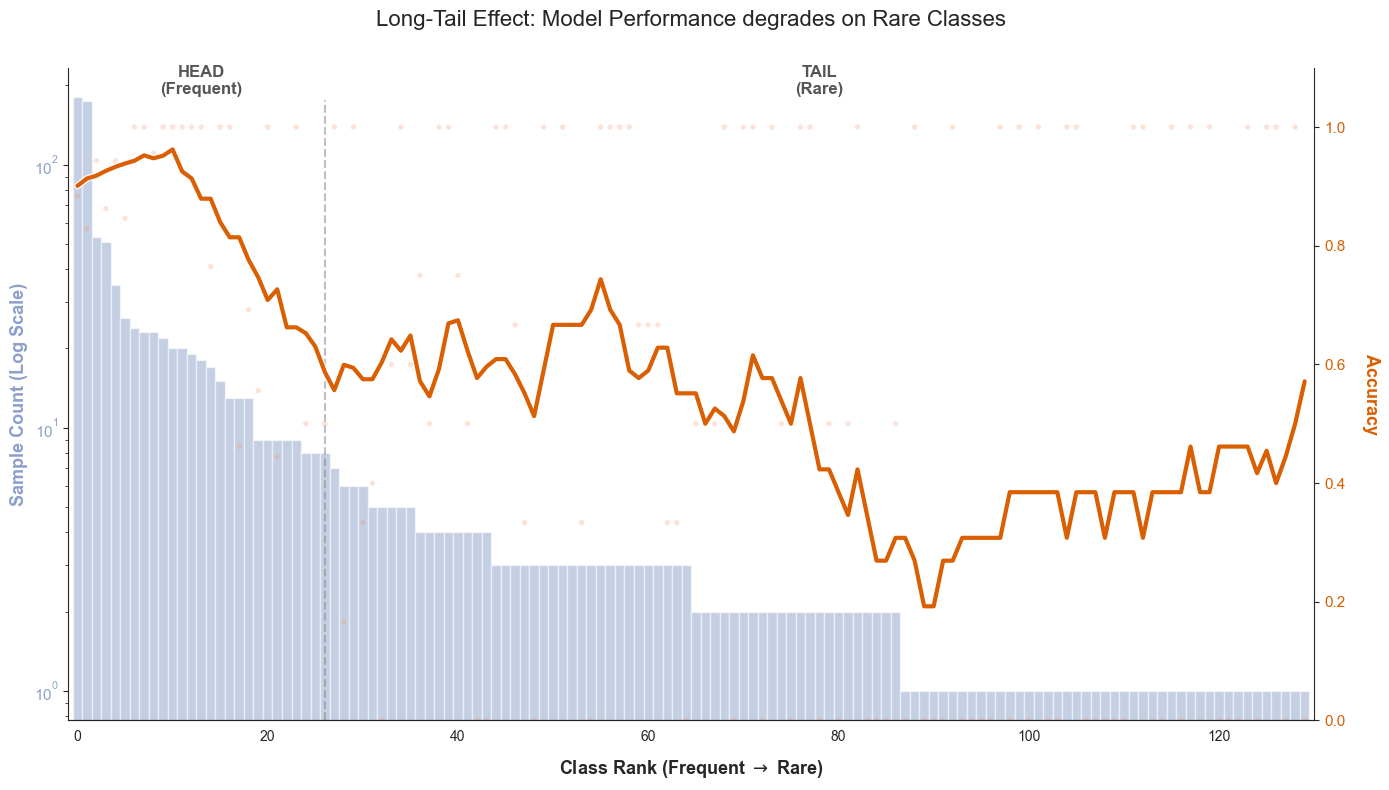

In [14]:
# 1. Setup Data (Assuming df_pc is already sorted by count)
df_pc = df_pc.sort_values("count", ascending=False).reset_index(drop=True)

# 2. Style Configuration
sns.set_style("white")  # Clean white background
plt.rcParams["font.family"] = "sans-serif"  # Modern, readable font

fig, ax1 = plt.subplots(figsize=(14, 8))

# Define colors (Colorblind-friendly palette)
color_bars = "#8da0cb"  # Muted Blue
color_dots = "#fc8d62"  # Muted Orange
color_line = "#d95f02"  # Deep Orange/Red

# --- LEFT AXIS: Sample Counts ---
x_indexes = np.arange(len(df_pc))
ax1.bar(
    x_indexes,
    df_pc["count"],
    color=color_bars,
    alpha=0.5,
    width=1.0,
    label="Sample Count",
)

# Styling Left Axis
ax1.set_xlabel(
    "Class Rank (Frequent $\\rightarrow$ Rare)",
    fontsize=13,
    fontweight="bold",
    labelpad=10,
)
ax1.set_ylabel(
    "Sample Count (Log Scale)", color=color_bars, fontsize=13, fontweight="bold"
)
ax1.tick_params(axis="y", labelcolor=color_bars, labelsize=11)
ax1.set_yscale("log")
ax1.set_xlim(-1, len(df_pc))

# Clean up borders
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# --- RIGHT AXIS: Accuracy ---
ax2 = ax1.twinx()
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# 1. Scatter (Raw Data)
ax2.scatter(
    x_indexes,
    df_pc["accuracy"],
    color=color_dots,
    alpha=0.25,  # More transparent to reduce noise visually
    s=15,  # Smaller dots
    edgecolor="none",
    label="Raw Class Accuracy",
)

# 2. Moving Average (Trend)
# Use a slightly larger window for a smoother curve
window = max(int(len(df_pc) * 0.10), 10)
rolling_acc = (
    df_pc["accuracy"].rolling(window=window, center=True, min_periods=1).mean()
)

# "Glow" effect for the line (white outline makes it stand out against bars)
ax2.plot(x_indexes, rolling_acc, color="white", linewidth=5, alpha=0.8)
(line,) = ax2.plot(
    x_indexes, rolling_acc, color=color_line, linewidth=3, label="Trend (Moving Avg)"
)

# Styling Right Axis
ax2.set_ylabel(
    "Accuracy",
    color=color_line,
    fontsize=13,
    fontweight="bold",
    rotation=270,
    labelpad=25,
)
ax2.tick_params(axis="y", labelcolor=color_line, labelsize=11)
ax2.set_ylim(0, 1.1)  # Give a little headroom for the legend

# --- ANNOTATIONS ---
# Add a vertical line to separate Head vs Tail (approximate at 20% of classes)
head_cutoff = int(len(df_pc) * 0.2)
ax1.axvline(head_cutoff, color="gray", linestyle="--", alpha=0.5, ymax=0.95)

# Text Labels for regions
ax2.text(
    head_cutoff / 2,
    1.05,
    "HEAD\n(Frequent)",
    ha="center",
    va="bottom",
    fontsize=12,
    color="#555555",
    fontweight="bold",
)
ax2.text(
    (head_cutoff + len(df_pc)) / 2,
    1.05,
    "TAIL\n(Rare)",
    ha="center",
    va="bottom",
    fontsize=12,
    color="#555555",
    fontweight="bold",
)

# --- TITLES & LEGEND ---
plt.title(
    "Long-Tail Effect: Model Performance degrades on Rare Classes", fontsize=16, pad=30
)

# Combined Legend placed at the top center
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.grid(True, axis="x", linestyle=":", alpha=0.3)
plt.tight_layout()
plt.show()

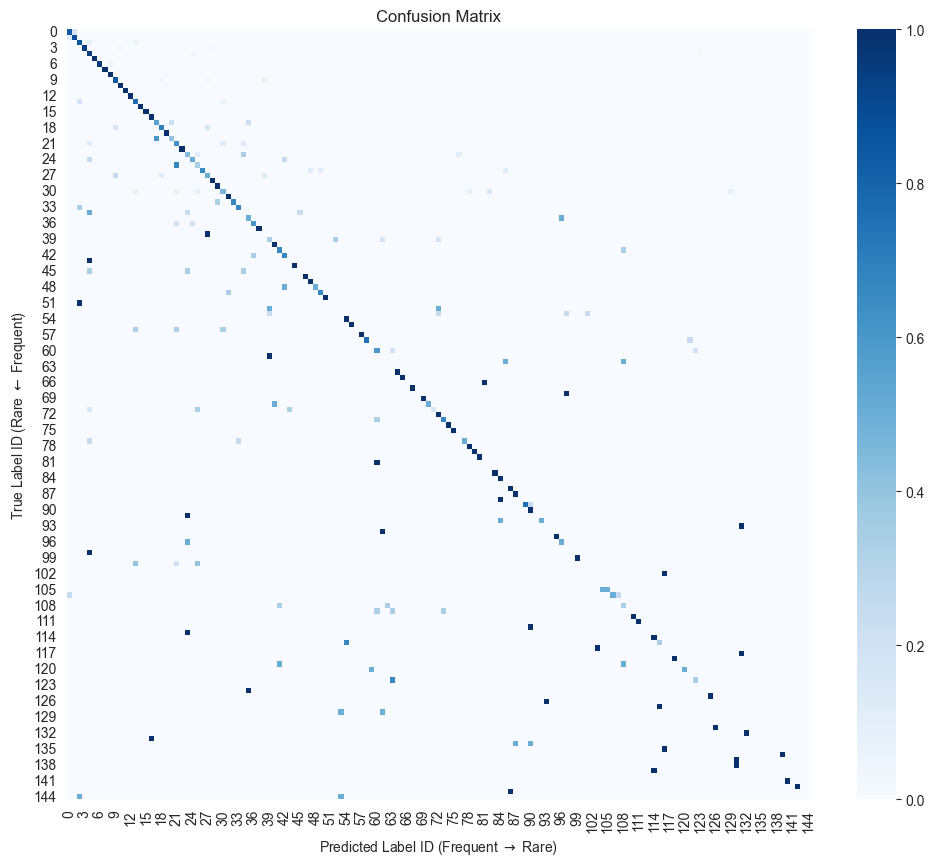

In [15]:
# Confusion matrix for all classes (normalized)
cm = confusion_matrix(gold_ids, pred_ids, normalize="true")
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel(r"Predicted Label ID (Frequent $\rightarrow$ Rare)")
plt.ylabel(r"True Label ID (Rare $\leftarrow$ Frequent)")
plt.show()


## 7. Generative Model: BLIP (LoRA) Analysis

In [16]:
df_generative = results_to_df(blip_test, "BLIP (LoRA)").round(4)
df_generative = df_generative.fillna("-")
df_generative

,model,subset,exact_match,token_f1,bleu,rougeL,bertscore_precision,bertscore_recall,bertscore_f1
0,BLIP (LoRA),OVERALL,0.6927,0.7364,-,-,-,-,-
1,BLIP (LoRA),OPEN,0.6202,0.6919,0.0311,0.7259,0.9194,0.9136,0.9162
2,BLIP (LoRA),CLOSED,0.8053,0.8053,-,-,-,-,-


## 8. Generative vs Discriminative Models

### 8.1. Fair Comparison (Exact Match + Token-F1 for all models)

CNN–LSTM models predict an answer **class index**, while BLIP generates free-form text.

To compare fairly across discriminative and generative models, we convert CNN predictions to text using the
training answer vocabulary (`id2ans`), then compute the same text metrics used for BLIP:
- Exact Match (normalized)
- Token-F1 (SQuAD-style)


In [17]:
@torch.no_grad()
def get_cnn_preds_as_text(
    model: torch.nn.Module,
    loader: DataLoader,
    device: str,
    id2ans: dict[int, str],
) -> tuple[list[str], list[str], list[str]]:
    model.eval().to(device)

    preds_text: list[str] = []
    golds_text: list[str] = []
    answer_types: list[str] = []

    for batch in tqdm(loader, desc="Getting CNN Predictions as Text"):
        images = batch["images"].to(device)
        questions = batch["questions"].to(device)
        labels = batch["labels"].cpu().tolist()

        logits = model(images, questions)
        pred_ids = logits.argmax(dim=1).detach().cpu().tolist()

        preds_text.extend([id2ans[i] for i in pred_ids])
        golds_text.extend([id2ans[i] for i in labels])
        answer_types.extend(batch["answer_types"])

    return preds_text, golds_text, answer_types


def compute_text_metrics_by_subset(preds_text, golds_text, answer_types):
    # overall
    overall = compute_text_metrics(preds_text, golds_text)

    # open
    open_idx = split_indices_by_answer_type(answer_types, "OPEN")
    open_metrics = compute_text_metrics(
        [preds_text[i] for i in open_idx],
        [golds_text[i] for i in open_idx],
    )

    # closed
    closed_idx = split_indices_by_answer_type(answer_types, "CLOSED")
    closed_metrics = compute_text_metrics(
        [preds_text[i] for i in closed_idx],
        [golds_text[i] for i in closed_idx],
    )

    return {"overall": overall, "open": open_metrics, "closed": closed_metrics}


# ---- CNN Frozen ----
cnn_frozen_preds_text, cnn_frozen_golds_text, cnn_frozen_types = get_cnn_preds_as_text(
    cnn_frozen, test_loader_cls, DEVICE, id2ans
)
cnn_frozen_text_results = compute_text_metrics_by_subset(
    cnn_frozen_preds_text, cnn_frozen_golds_text, cnn_frozen_types
)

# ---- CNN Unfrozen ----
cnn_unfrozen_preds_text, cnn_unfrozen_golds_text, cnn_unfrozen_types = (
    get_cnn_preds_as_text(cnn_unfrozen, test_loader_cls, DEVICE, id2ans)
)
cnn_unfrozen_text_results = compute_text_metrics_by_subset(
    cnn_unfrozen_preds_text, cnn_unfrozen_golds_text, cnn_unfrozen_types
)

print("CNN Frozen text metrics:", cnn_frozen_text_results)
print("CNN Unfrozen text metrics:", cnn_unfrozen_text_results)


Getting CNN Predictions as Text: 100%|██████████| 34/34 [00:04<00:00,  6.95it/s]

CNN Frozen text metrics: {'overall': {'exact_match': 0.7983034872761545, 'token_f1': 0.8253061814089148}, 'open': {'exact_match': 0.7767441860465116, 'token_f1': 0.8211625712788503}, 'closed': {'exact_match': 0.8317307692307693, 'token_f1': 0.8317307692307693}}
CNN Unfrozen text metrics: {'overall': {'exact_match': 0.7766258246936852, 'token_f1': 0.813095277327134}, 'open': {'exact_match': 0.7472868217054264, 'token_f1': 0.807277657742774}, 'closed': {'exact_match': 0.8221153846153846, 'token_f1': 0.8221153846153846}}


In [18]:
def fair_compare_df(cnn_frozen_text, cnn_unfrozen_text, blip_test):
    rows = []
    for subset in ["overall", "open", "closed"]:
        rows.append(
            {
                "model": "CNN-LSTM (Frozen)",
                "subset": subset.upper(),
                "exact_match": cnn_frozen_text[subset]["exact_match"],
                "token_f1": cnn_frozen_text[subset]["token_f1"],
            }
        )
        rows.append(
            {
                "model": "CNN-LSTM (Unfrozen)",
                "subset": subset.upper(),
                "exact_match": cnn_unfrozen_text[subset]["exact_match"],
                "token_f1": cnn_unfrozen_text[subset]["token_f1"],
            }
        )
        rows.append(
            {
                "model": "BLIP (LoRA)",
                "subset": subset.upper(),
                "exact_match": blip_test[subset]["exact_match"],
                "token_f1": blip_test[subset]["token_f1"],
            }
        )

    return pd.DataFrame(rows).round(4)


df_fair = fair_compare_df(cnn_frozen_text_results, cnn_unfrozen_text_results, blip_test)
df_fair


,model,subset,exact_match,token_f1
0,CNN-LSTM (Frozen),OVERALL,0.7983,0.8253
1,CNN-LSTM (Unfrozen),OVERALL,0.7766,0.8131
2,BLIP (LoRA),OVERALL,0.6927,0.7364
3,CNN-LSTM (Frozen),OPEN,0.7767,0.8212
4,CNN-LSTM (Unfrozen),OPEN,0.7473,0.8073
5,BLIP (LoRA),OPEN,0.6202,0.6919
6,CNN-LSTM (Frozen),CLOSED,0.8317,0.8317
7,CNN-LSTM (Unfrozen),CLOSED,0.8221,0.8221
8,BLIP (LoRA),CLOSED,0.8053,0.8053


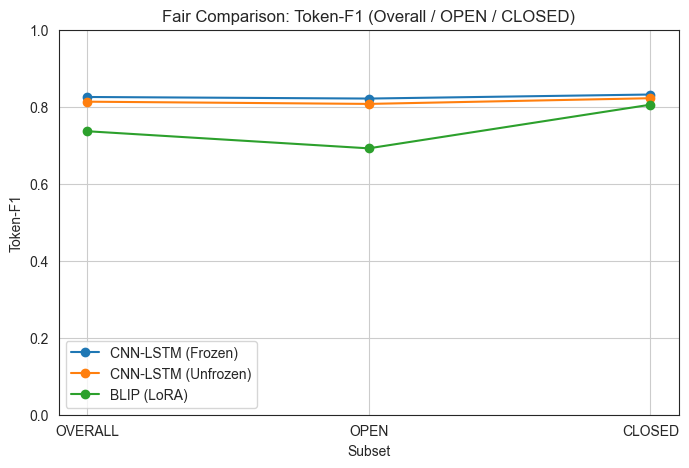

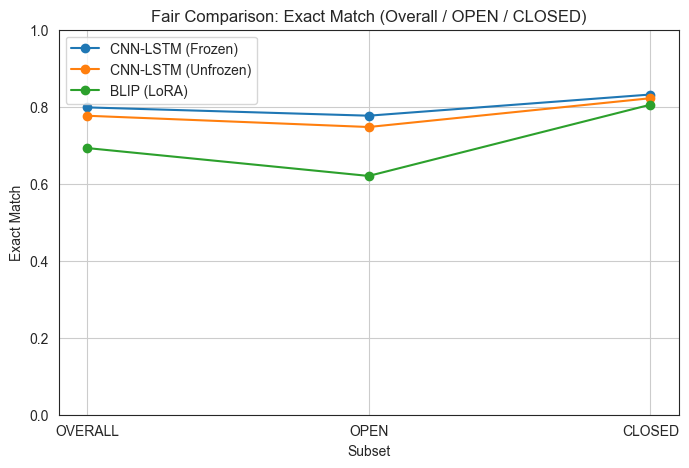

In [19]:
def plot_fair_tokenf1(df_fair: pd.DataFrame):
    subsets = ["OVERALL", "OPEN", "CLOSED"]
    models = df_fair["model"].unique().tolist()

    plt.figure(figsize=(8, 5))

    for m in models:
        vals = []
        for s in subsets:
            vals.append(
                df_fair[(df_fair["model"] == m) & (df_fair["subset"] == s)][
                    "token_f1"
                ].values[0]
            )
        plt.plot(subsets, vals, marker="o", label=m)

    plt.ylim(0, 1)
    plt.title("Fair Comparison: Token-F1 (Overall / OPEN / CLOSED)")
    plt.xlabel("Subset")
    plt.ylabel("Token-F1")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_fair_exactmatch(df_fair: pd.DataFrame):
    subsets = ["OVERALL", "OPEN", "CLOSED"]
    models = df_fair["model"].unique().tolist()

    plt.figure(figsize=(8, 5))

    for m in models:
        vals = []
        for s in subsets:
            vals.append(
                df_fair[(df_fair["model"] == m) & (df_fair["subset"] == s)][
                    "exact_match"
                ].values[0]
            )
        plt.plot(subsets, vals, marker="o", label=m)

    plt.ylim(0, 1)
    plt.title("Fair Comparison: Exact Match (Overall / OPEN / CLOSED)")
    plt.xlabel("Subset")
    plt.ylabel("Exact Match")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_fair_tokenf1(df_fair)
plot_fair_exactmatch(df_fair)


## 8.2. Qualitative Evaluation: CNN vs BLIP

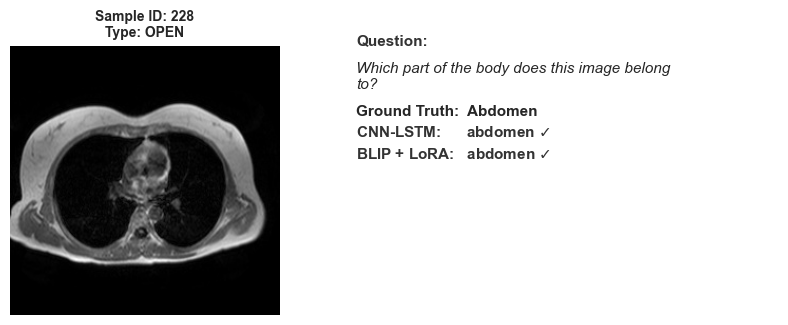

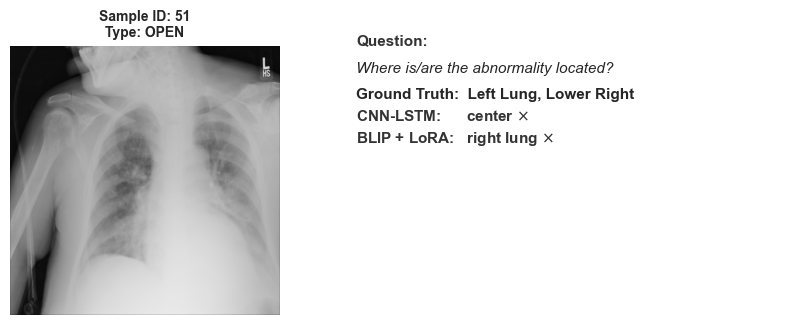

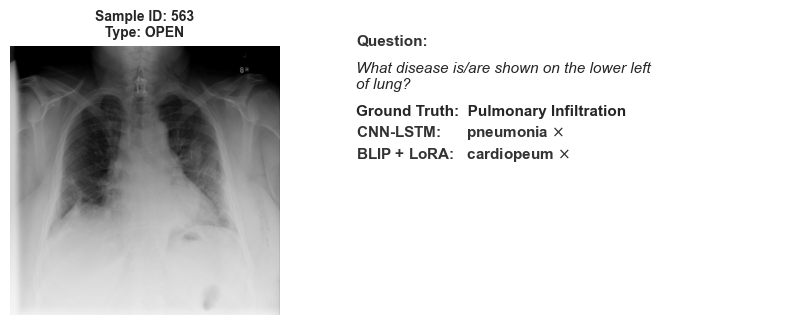

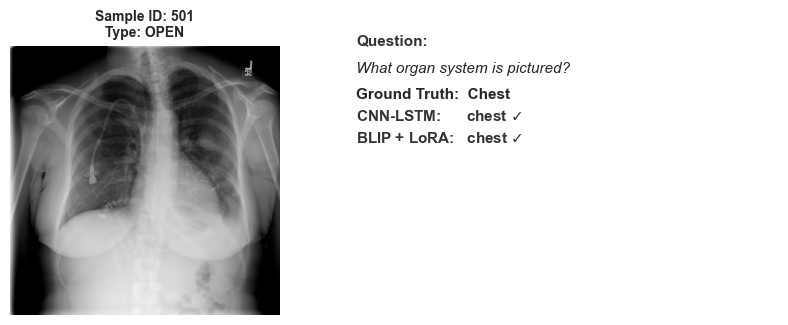

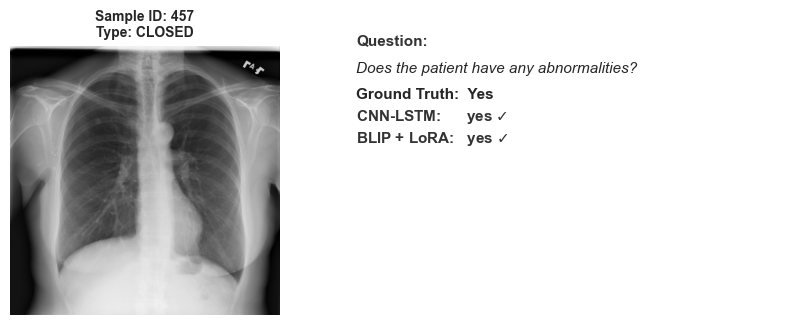

In [20]:
def qualitative_examples_latex(
    cnnlstm, blip_lora, n=5, seed=42, max_new_tokens=20, device="cuda"
):
    random.seed(seed)
    n = min(n, len(test_ds_blip))
    idxs = random.sample(range(len(test_ds_blip)), n)

    cnnlstm = cnnlstm.to(device)
    cnnlstm.eval()
    blip_lora = blip_lora.to(device)
    blip_lora.eval()

    # Helper: Returns LaTeX string for tick/cross
    def get_status(pred, gold):
        if pred.strip().lower() == gold.strip().lower():
            return r" $\checkmark$"  # LaTeX Tick
        else:
            return r" $\times$"  # LaTeX Cross

    for idx in idxs:
        # Load Data
        sample_blip = test_ds_blip[idx]
        sample_cls = test_ds_cls[idx]

        q = sample_blip["question"]
        gold = sample_blip["answer"]
        atype = sample_blip["answer_type"]
        image = sample_blip["image"]

        # --- 1. CNN-LSTM Inference ---
        with torch.no_grad():
            img_t = sample_cls["image"].unsqueeze(0).to(device)
            ques_t = sample_cls["question"].unsqueeze(0).to(device)
            logits = cnnlstm(img_t, ques_t)
            pred_id = logits.argmax(dim=1).item()
            cnn_pred = id2ans.get(pred_id, "<unk>")

        # --- 2. BLIP Inference ---
        with torch.no_grad():
            inputs = processor(images=image, text=q, return_tensors="pt").to(device)
            gen_ids = blip_lora.generate(**inputs, max_new_tokens=max_new_tokens)
            blip_pred = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        # --- 3. Visualization ---
        fig, (ax_img, ax_txt) = plt.subplots(
            1, 2, figsize=(10, 3.5), gridspec_kw={"width_ratios": [1, 1.5]}
        )

        # A) Show Image
        ax_img.imshow(image)
        ax_img.axis("off")
        ax_img.set_title(
            f"Sample ID: {idx}\nType: {atype}", fontsize=10, fontweight="bold"
        )

        # B) Show Text Details
        ax_txt.axis("off")
        y_cursor = 1.0

        # Reduced spacing here (was 0.15)
        line_spacing = 0.08

        # 1. Question
        wrapped_q = textwrap.fill(q, width=45)  # Increased width slightly
        ax_txt.text(
            0, y_cursor, "Question:", fontsize=11, fontweight="bold", color="#333333"
        )
        ax_txt.text(
            0, y_cursor - 0.06, wrapped_q, fontsize=11, va="top", style="italic"
        )

        # Dynamic cursor adjustment
        num_lines = wrapped_q.count("\n") + 2
        y_cursor -= 0.08 + num_lines * 0.06

        # 2. Ground Truth
        ax_txt.text(
            0, y_cursor, f"Ground Truth:  {gold}", fontsize=11, fontweight="bold"
        )
        y_cursor -= line_spacing

        # 3. CNN Result (with LaTeX Tick/Cross)
        status = get_status(cnn_pred, gold)
        ax_txt.text(
            0,
            y_cursor,
            f"CNN-LSTM:      {cnn_pred}{status}",
            fontsize=11,
            fontweight="bold",
            color="#333333",
        )
        y_cursor -= line_spacing

        # 4. BLIP Result (with LaTeX Tick/Cross)
        status = get_status(blip_pred, gold)
        ax_txt.text(
            0,
            y_cursor,
            f"BLIP + LoRA:   {blip_pred}{status}",
            fontsize=11,
            fontweight="bold",
            color="#333333",
        )

        # plt.tight_layout()
        plt.show()


# Run it
qualitative_examples_latex(best_cnn_model, blip_lora, n=5, seed=42, device=DEVICE)